In [2]:
import modules.board_module as bf
import modules.tree_module as tf
import modules.stockfish_module as sf
from ModelSaver import ModelSaver
import random
from dataclasses import dataclass
from collections import namedtuple
import itertools
import time
import argparse
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from datetime import datetime
from math import floor, ceil
import pandas as pd

from train_nn_evaluator import Trainer, EvalDataset, ChessNet, ResNet
from assemble_data import Move, Position

In [3]:
# load in the entire dataset
num_rand = 4096
datapath = "/home/luke/chess/python/gamedata/samples"
eval_file_template = "random_n={0}_sample"
inds = list(range(1))
log_level = 1
dataset = EvalDataset(datapath, eval_file_template.format(num_rand),
                      indexes=inds, log_level=log_level)

Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_339.lz4 with pickle ... finished
EvalDataset(): 1 files loaded 0.24 seconds


In [4]:
process_data = False

if process_data:

  print(f"Total number of positions = {len(dataset)}")
  num_duplicates = dataset.check_duplicates()
  num_mates = dataset.check_mate_positions()
  print(f"Proportion of duplicates = {(num_duplicates / len(dataset))*100:.1f} %")
  print(f"Proportion of mate positions = {(num_mates / len(dataset))*100:.1f} %")

  # prepare the dataset
  print("REMOVING MATES AND DUPLICATES")
  num_duplicates = dataset.check_duplicates(remove=True)
  num_mates = dataset.check_mate_positions(remove=True)
  dataset.board_dtype = torch.float
  dataset.to_torch()

In [5]:
savenew = False

if savenew:

  dataset_name = "datasetv2"
  file_name = "data"
  ind_per = 2               # indexes per slice of the dataset
  total_index = 140         # largest index number of gamedata/samples file
  prevent_duplicates = True # prevent duplicates across the entire set, not just in each slice
  savetorchonly = False     # save only the finalised torch tensors
  savetorchtoo = True       # save also a torch version of the dataset
  log_level = 1             # log level during the dataset generation (0=bare minimum, 1=normal)

  num_sets = total_index // ind_per
  if prevent_duplicates: seen_values = set()

  datasaver = ModelSaver("/home/luke/chess/python/datasets/", log_level=log_level)
  datasaver.new_folder(dataset_name)

  for ind in range(num_sets):

    print("Loading set", ind + 1, "/", num_sets)
    indexes = list(range(ind * ind_per + 1, ((ind + 1) * ind_per) + 1))
    dataset = EvalDataset(datapath, eval_file_template.format(num_rand),
                          indexes=indexes, log_level=log_level)
    if prevent_duplicates: dataset.seen_values = seen_values
    num_duplicates = dataset.check_duplicates(remove=True, wipe_seen=not prevent_duplicates)
    num_mates = dataset.check_mate_positions(remove=True)
    dataset.board_dtype = torch.float
    dataset.to_torch()
    if savetorchonly or savetorchtoo:
      if dataset.eval_squares:
        datasaver.save(file_name + "_torch", [dataset.boards, dataset.evals, dataset.square_evals])
      else:
        datasaver.save(file_name + "_torch", [dataset.boards, dataset.evals])
    elif not savetorchonly:
      datasaver.save(file_name, dataset)
    if prevent_duplicates: seen_values = dataset.seen_values

In [6]:
savenew_randomised = False

if savenew_randomised:

  dataset_name = "datasetv8"
  file_name = "data"
  max_files = None          # maximum number of files to generate, default=None
  num_per = 200_000         # number of lines per saved file
  total_index = 337         # largest index number of gamedata/samples file
  prevent_duplicates = True # prevent duplicates across the entire set, not just in each slice
  log_level = 1             # log level during the dataset generation (0=bare minimum, 1=normal)

  # variables for distribution characterisation
  clip_checkmate = 15       # only for distribution analysis - does NOT apply to dataset itself
  num_bins = 100            # number of histogram bins to save data for

  datasaver = ModelSaver("/home/luke/chess/python/datasets/", log_level=log_level)
  datasaver.new_folder(dataset_name)

  indexes = list(range(1, total_index + 1))
  dataset = EvalDataset(datapath, eval_file_template.format(num_rand),
                          indexes=indexes, log_level=log_level)
  
  # ensure key settings are correct
  dataset.use_eval_normalisation = False
  dataset.save_sq_eval = True

  # remove any duplicates and mate positions
  num_duplicates = dataset.check_duplicates(remove=True)
  num_mates = dataset.check_mate_positions(remove=True)
  # dataset.to_torch() # old, convert ALL to torch

  # now randomise a selection of the indexes
  num_pos = len(dataset.positions)
  num_boards = dataset.count_all_positions()
  indexes = list(range(num_boards))
  random.shuffle(indexes)

  num_files = num_boards // num_per
  ind = 0

  if max_files is not None:
    if num_files > max_files:
      print(f"The number of files is limited from {num_files} to {max_files}")
      num_files = max_files

  print("num_files is", num_files)
  print("num_boards is", num_boards)

  # prepare to save distribution data
  sf_file_means = []
  sf_file_var = []
  sf_file_max = []
  my_file_means_raw = []
  my_file_var_raw = []
  my_file_max_raw = []
  my_file_means_sum = []
  my_file_var_sum = []
  my_file_max_sum = []
  both_file_means = []
  both_file_var = []
  both_file_max = []
  sf_bins = np.linspace(-clip_checkmate, clip_checkmate, num_bins)
  my_bins_raw = np.linspace(-clip_checkmate, clip_checkmate, num_bins)
  my_bins_sum = np.linspace(-clip_checkmate, clip_checkmate, num_bins)
  sf_bin_counts = np.zeros(num_bins - 1)
  my_raw_bin_counts = np.zeros(num_bins - 1)
  my_sum_bin_counts = np.zeros(num_bins - 1)
  
  for n in range(num_files):

    # random selection of indexes for the current file
    these_indexes = indexes[n * num_per : (n + 1) * num_per]
    
    # convert only the selected indexes to torch
    dataset.to_torch(indexes_only=these_indexes)

    # save the converted tensors
    datasaver.save(file_name + "_torch", [dataset.boards, dataset.evals, dataset.square_evals])

    # now prepare to analyse the distribution
    data_sf = dataset.evals
    data_my_raw = dataset.square_evals
    data_my_sum = torch.sum(dataset.square_evals, dim=1)
    data_both = torch.cat((dataset.evals.unsqueeze(1), dataset.square_evals), dim=1)

    # calculate max, and then clip large values to prevent distribution skew
    sf_file_max.append(torch.max(torch.abs(data_sf)).item())
    my_file_max_raw.append(torch.max(torch.abs(data_my_raw)).item())
    my_file_max_sum.append(torch.max(torch.abs(data_my_sum)).item())
    both_file_max.append(torch.max(torch.abs(data_both)).item())
    data_sf = torch.clip(data_sf, -clip_checkmate, clip_checkmate)
    data_my_raw = torch.clip(data_my_raw, -clip_checkmate, clip_checkmate)
    data_my_sum = torch.clip(data_my_sum, -clip_checkmate, clip_checkmate)
    data_both = torch.clip(data_both, -clip_checkmate, clip_checkmate)

    # calculate mean, variance, max
    sf_file_means.append(torch.mean(data_sf).item())
    sf_file_var.append(torch.var(data_sf).item())
    my_file_means_raw.append(torch.mean(data_my_raw).item())
    my_file_var_raw.append(torch.var(data_my_raw).item())
    my_file_means_sum.append(torch.mean(data_my_sum).item())
    my_file_var_sum.append(torch.var(data_my_sum).item())
    both_file_means.append(torch.mean(data_both).item())
    both_file_var.append(torch.var(data_both).item())

    # calculate distribution histogram
    sf_counts, _ = np.histogram(data_sf.detach().numpy(), bins=sf_bins)
    my_raw_counts, _ = np.histogram(data_my_raw.detach().numpy(), bins=sf_bins)
    my_sum_counts, _ = np.histogram(data_my_sum.detach().numpy(), bins=sf_bins)
    sf_bin_counts += sf_counts
    my_raw_bin_counts += my_raw_counts
    my_sum_bin_counts += my_sum_counts

  # finish by calculating distribution data over the new dataset
  my_means_raw = np.array(my_file_means_raw)
  my_overall_mean_raw = np.mean(my_means_raw)
  my_overal_std_raw = np.sqrt(np.mean(my_file_var_raw) + np.mean(np.power(my_means_raw - my_overall_mean_raw, 2)))
  my_max_raw = np.max(my_file_max_raw)
  my_means_sum = np.array(my_file_means_sum)
  my_overall_mean_sum = np.mean(my_means_sum)
  my_overal_std_sum = np.sqrt(np.mean(my_file_var_sum) + np.mean(np.power(my_means_sum - my_overall_mean_sum, 2)))
  my_max_sum = np.max(my_file_max_sum)
  sf_means = np.array(sf_file_means)
  sf_overall_mean = np.mean(sf_means)
  sf_overal_std = np.sqrt(np.mean(sf_file_var) + np.mean(np.power(sf_means - sf_overall_mean, 2)))
  sf_max = np.max(sf_file_max)
  both_means = np.array(both_file_means)
  both_overall_mean = np.mean(both_means)
  both_overal_std = np.sqrt(np.mean(both_file_var) + np.mean(np.power(both_means - both_overall_mean, 2)))
  both_max = np.max(both_file_max)

  summary_str = """"""
  summary_str += f"Dataset name: {dataset_name}\n"
  summary_str += f"Number of loaded files: {total_index}\n"
  summary_str += f"Number of core positions: {num_pos}\n"
  summary_str += f"Number of total boards: {num_boards}\n"
  summary_str += f"Number of created dataset files: {num_files}\n"
  summary_str += "\nDistribution data:\n"
  summary_str += f"Stockfish (mean, std, max) = ({sf_overall_mean:.3f}, {sf_overal_std:.3f}, {sf_max:.3f})\n"
  summary_str += f"My evals per square (mean, std, max) = ({my_overall_mean_raw:.3f}, {my_overal_std_raw:.3f}, {my_max_raw:.3f})\n"
  summary_str += f"My evals per board (mean, std, max) = ({my_overall_mean_sum:.3f}, {my_overal_std_sum:.3f}, {my_max_sum:.3f})\n"
  summary_str += f"Both (mean, std, max) = ({both_overall_mean:.3f}, {both_overal_std:.3f}, {both_max:.3f})\n"

  # save the summary string and distribution data
  datasaver.save("summary", txtonly=True, txtstr=summary_str)
  datasaver.save("distribution", [
    (sf_bin_counts, my_raw_bin_counts, my_sum_bin_counts), 
    (sf_bins, my_bins_raw, my_bins_sum),
    ((sf_overall_mean, sf_overal_std, sf_max),
     (my_overall_mean_raw, my_overal_std_raw, my_max_raw),
     (both_overall_mean, both_overal_std, both_max)),
  ], suffix_numbering=False)

  print(summary_str)

In [7]:
if savenew_randomised:

  fig, axs = plt.subplots(3, 1, sharex=True)
  axs[0].bar(sf_bins[:-1], sf_bin_counts, width=np.diff(sf_bins), align="edge")
  axs[1].bar(my_bins_raw[:-1], my_raw_bin_counts, width=np.diff(my_bins_raw), align="edge")
  axs[2].bar(my_bins_sum[:-1], my_sum_bin_counts, width=np.diff(my_bins_sum), align="edge")

  fig.suptitle(f"Dataset: {dataset_name}, num_boards = {int(num_files * num_per / 1e3)}k")
  axs[0].set_title(f"stockfish evaluations")
  axs[1].set_title(f"per square piece evaluations")
  axs[2].set_title(f"my evaluations")

  for a in axs:
    a.set_ylabel("Frequency")
  axs[2].set_xlabel("Evaluation score / pawns")

  fig.tight_layout()

Loading file /home/luke/chess//python/datasets/datasetv8/distribution.lz4 with pickle ... finished
Loading file /home/luke/chess//python/datasets/datasetv8/data_torch_001.lz4 with pickle ... finished
The number of samples was 200000


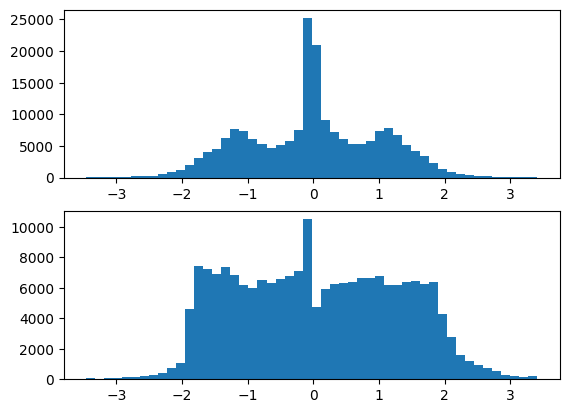

In [ ]:
datestr = "%d-%m-%y_%H-%M" # all date inputs must follow this format
timestamp = datetime.now().strftime(datestr)
run_name = f"run_{timestamp[-5:]}_A{1}"
group_name = timestamp[:8]

train_num = 160
test_num = 7

# saving/loading information
data_dict = {
  "path" : "/home/luke/chess",
  "loadpath" : "/python/datasets",
  "loadfolder" : "datasetv8",
  "loadname" : "data_torch",
  "savepath" : "/python/models",
  "savefolder" : f"{group_name}/{run_name}",
  "savename" : "network",
  "train_inds" : list(range(1, train_num + 1)),
  "test_inds" : list(range(train_num + 1, 
                           train_num + test_num + 1)),
  "sample_method" : "weighted",
  "load_log_level" : 1,
  "save_log_level" : 1,
}

# create the trainer object
trainer = Trainer(data_dict)
# trainer.norm_factors = [10, 0, 4]
trainer.batch_limit = None
trainer.params.use_combined_loss = False
trainer.params.use_sf_eval = True

# # load in the dataset distribution data
# [sf_bin_counts, my_raw_bin_counts, my_sum_bin_counts] = trainer.dataloader.load("distribution", suffix_numbering=False)

batch_size = 64
total_batches = 0
device = "cpu"

# load the dataset in a series of slices (with randomised order)
train_load_indexes = trainer.data_dict['train_inds'][:]
random.shuffle(train_load_indexes)

train_load_indexes = [1]

num_batches = 200_000 // batch_size 
if trainer.batch_limit is not None: num_batches = trainer.batch_limit
samples = torch.zeros(batch_size * num_batches * len(train_load_indexes))
w_samples = torch.zeros(batch_size * num_batches * len(train_load_indexes))
sample_ind = 0
w_sample_ind = 0

for slice_num, j in enumerate(train_load_indexes):

  # load this segment of the dataset
  data_x, data_y, sf_evals, sq_evals = trainer.prepare_data(trainer.data_dict['loadname'], j, return_dataset=True)

  num_batches = len(data_x) // batch_size
  if num_batches == 0:
    raise RuntimeError("Trainer.train() found num_batches = 0")
  
  # useful for debugging and testing
  if trainer.batch_limit is not None:
    num_batches = trainer.batch_limit

  total_batches += num_batches
  rand_idx = torch.randperm(data_x.shape[0])
  avg_loss = 0

  t1 = time.time()

  trainer.weighted_sample_num_combined_bins = 20
  sampler = trainer.create_weighted_sampler(sf_evals)

  # iterate through each batch for this slice of the dataset
  for n in range(num_batches):

    # get a normal sample
    batch_x = data_x[rand_idx[n * batch_size : (n+1) * batch_size]]
    batch_y = data_y[rand_idx[n * batch_size : (n+1) * batch_size]]

    samples[sample_ind : sample_ind + batch_size] = batch_y
    sample_ind += batch_size

    # now get a weighted sample
    # w_x = data_x[w_sample_indicies[n * batch_size : (n+1) * batch_size]]
    # w_y = data_y[w_sample_indicies[n * batch_size : (n+1) * batch_size]]

    w_sample_indicies = list(sampler)
    w_x = data_x[w_sample_indicies]
    w_y = data_y[w_sample_indicies]

    w_samples[w_sample_ind : w_sample_ind + batch_size] = w_y
    w_sample_ind += batch_size

    # # go to device (small memory footprint, slightly slower)
    # batch_x = batch_x.to(device)
    # batch_y = batch_y.to(device)

print(f"The number of samples was {sample_ind}")

fig, axs = plt.subplots(2, 1)
axs[0].hist(samples.detach().numpy(), bins=50)
axs[1].hist(w_samples.detach().numpy(), bins=50)
plt.show()

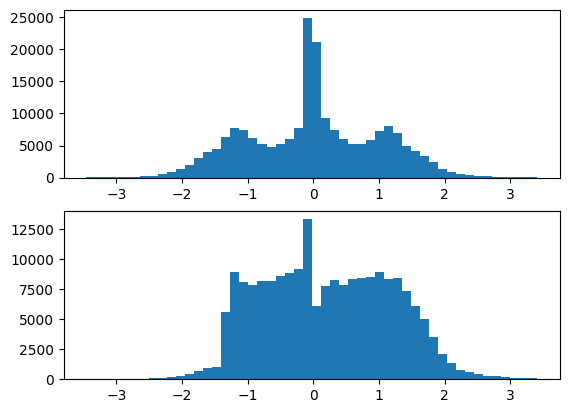

In [9]:
fig, axs = plt.subplots(2, 1)
axs[0].hist(samples.detach().numpy(), bins=50)
axs[1].hist(w_samples.detach().numpy(), bins=50)
plt.show()

In [10]:
# bin_probs = torch.tensor(sf_bin_counts / np.sum(sf_bin_counts))
# clip_checkmate = 15
# num_bins = 50
# bins = np.linspace(-clip_checkmate, clip_checkmate, num_bins)
# weight_vec = torch.zeros(data_y.shape[0])
# weight_vec = weight_vec.copy_(data_y)

# scores = trainer.denormalise_data(data_y)
# print(scores[0:10])
# scores += num_bins // 2
# inds = torch.floor(scores).long()

# weight_vec = bin_probs[inds]



# print(bin_probs)
# print(scores[0:10])
# print(inds[0:10])
# print(weight_vec[0:10])

print([np.sum(sf_bin_counts[:combine_bins])])
print(sf_bin_counts[combine_bins:num_bins - combine_bins])
print([np.sum(sf_bin_counts[num_bins - combine_bins:])])

pooled_counts = np.pad(
  array=sf_bin_counts[combine_bins:num_bins - combine_bins],
  pad_width=(1,1),
  mode="constant",
  constant_values=(
    np.sum(sf_bin_counts[:combine_bins]),
    np.sum(sf_bin_counts[num_bins - combine_bins:])
  )
)

print(pooled_counts)

NameError: name 'combine_bins' is not defined

In [ ]:
load_kaggle = False
convert_kaggle = False
save_kaggle = False
new_kaggle_set = False

if load_kaggle:

  datapath = "/home/luke/chess/python/gamedata/kaggle"
  file_name = "chessData.csv"

  df = pd.read_csv(datapath + "/" + file_name)

if convert_kaggle:

  mate_value = 15 * 100
  positions = []
  print(f"The number of positions is {len(df['FEN'])}")

  # add all of the positions into the dataset
  for i in range(len(df["FEN"])):

    if i % 100_000 == 0: print(i / 1_000_000, end=" ")
    if i % 1_000_000 == 0: print()

    eval = df["Evaluation"][i]
    if eval.startswith("#+"):
      eval = mate_value
    elif eval.startswith("#-"):
      eval = -mate_value

    eval = int(eval)

    new_pos = Position(df["FEN"][i], eval, None)
    positions.append(new_pos)

if save_kaggle:

  tempsaver = ModelSaver(datapath)
  tempsaver.save("positions", positions)

if new_kaggle_set:

  dataset_name = "dataset_kaggle_2"
  file_name = "data"
  max_files = None          # maximum number of files to generate, default=None
  num_per = 200_000         # number of lines per saved file
  prevent_duplicates = True # prevent duplicates across the entire set, not just in each slice
  log_level = 1             # log level during the dataset generation (0=bare minimum, 1=normal)

  datasaver = ModelSaver("/home/luke/chess/python/datasets/", log_level=log_level)
  datasaver.new_folder(dataset_name)

  dataset = EvalDataset("", "", auto_load=False, log_level=log_level)
  
  # ensure key settings are correct
  dataset.use_all_moves = False
  dataset.use_eval_normalisation = False
  dataset.save_sq_eval = True

  # add in the kaggle positions
  dataset.positions = positions

  # remove any duplicates and mate positions
  num_duplicates = dataset.check_duplicates(remove=True)
  num_mates = dataset.check_mate_positions(remove=True)
  # dataset.to_torch() # old, convert ALL to torch

  # now randomise a selection of the indexes
  num_boards = dataset.count_all_positions()
  indexes = list(range(num_boards))
  random.shuffle(indexes)

  num_files = num_boards // num_per
  ind = 0

  if max_files is not None:
    if num_files > max_files:
      print(f"The number of files is limited from {num_files} to {max_files}")
      num_files = max_files

  print("num_files is", num_files)
  print("num_boards is", num_boards)
  
  for n in range(num_files):

    # random selection of indexes for the current file
    these_indexes = indexes[n * num_per : (n + 1) * num_per]
    
    # convert only the selected indexes to torch
    dataset.to_torch(indexes_only=these_indexes)

    # save the converted tensors
    datasaver.save(file_name + "_torch", [dataset.boards, dataset.evals, dataset.square_evals])

In [ ]:
class EvalDataset(torch.utils.data.Dataset):

  def __init__(self, datapath, sample_names, auto_load=True, indexes=None, log_level=1):
    """
    Dataset containint stockfish evaluations of chess positions. Pass in the
    path to the samples, their names, and the indexes to load
    """

    t1 = time.time()

    self.log_level = log_level
    self.positions = []
    self.seen_values = None
    self.num_lines = None

    self.mate_value = 50                # value of a checkmate (units: 1.0 per pawn)
    self.convert_evals_to_pawns = True  # convert evaluations from 1000 per pawn, to 1.0 per pawn
    self.use_all_moves = True           # add in all child moves from a positions, instead of the parent
    self.save_sq_eval = True            # evaluate every square in the board using my handcrafted evaluator
    self.use_eval_normalisation = False # apply normalisation to all evaluations
    self.norm_method = "standard"       # normalisation method to use, standard is mean/std scale -1/+1 bound
    self.norm_factor = None             # normalisation factors saved for future use
    self.board_dtype = torch.float      # datatype to use for torch tensors
    self.stockfish_converstion = 1e-2   # stockfish evals are in 1/100th of a pawn, so 200 = 2 pawns
    self.my_conversion = 1e-3           # my evals are in 1/1000th of a pawn, so 2000 = 2 pawns

    # create empty containers for future data
    self.boards = []
    self.evals = []
    self.square_evals = []

    if auto_load:

      self.modelsaver = ModelSaver(datapath, log_level=log_level)

      # automatically get all indexes if not specified
      if indexes is None:
        indexes = list(range(self.modelsaver.get_recent_file(name=sample_names, 
                                                            return_int=True) + 1))

      for ind in indexes:
        newdata = self.modelsaver.load(sample_names, id=ind)
        self.positions += newdata

      t2 = time.time()

      if self.log_level >= 1:
        print(f"EvalDataset(): {len(indexes)} files loaded {t2 - t1:.2f} seconds")

  def __len__(self):
    return len(self.positions)
  
  def __getitem__(self, idx):
    if idx > len(self.positions):
      raise RuntimeError(f"EvalDataset.__getitem__() error: idx ({idx}) > number of samples (len{self.positions})")
    
    return self.positions[idx]
  
  def FEN_to_torch(self, fen_string, move=None, eval_sqs=False):
    """
    Convert an FEN string into a torch tensor board representation
    """

    if move is None:
      if eval_sqs:
        boardvec = bf.FEN_to_board_vectors_with_eval(fen_string)
      else:
        boardvec = bf.FEN_to_board_vectors(fen_string)
    else:
      if eval_sqs:
        boardvec = bf.FEN_move_eval_to_board_vectors(fen_string, move)
      else:
        boardvec = bf.FEN_and_move_to_board_vectors(fen_string, move)

    tensortype = self.board_dtype

    t_wP = torch.tensor(boardvec.wP, dtype=tensortype).reshape(8, 8)
    t_wN = torch.tensor(boardvec.wN, dtype=tensortype).reshape(8, 8)
    t_wB = torch.tensor(boardvec.wB, dtype=tensortype).reshape(8, 8)
    t_wR = torch.tensor(boardvec.wR, dtype=tensortype).reshape(8, 8)
    t_wQ = torch.tensor(boardvec.wQ, dtype=tensortype).reshape(8, 8)
    t_wK = torch.tensor(boardvec.wK, dtype=tensortype).reshape(8, 8)
    t_bP = torch.tensor(boardvec.bP, dtype=tensortype).reshape(8, 8)
    t_bN = torch.tensor(boardvec.bN, dtype=tensortype).reshape(8, 8)
    t_bB = torch.tensor(boardvec.bB, dtype=tensortype).reshape(8, 8)
    t_bR = torch.tensor(boardvec.bR, dtype=tensortype).reshape(8, 8)
    t_bQ = torch.tensor(boardvec.bQ, dtype=tensortype).reshape(8, 8)
    t_bK = torch.tensor(boardvec.bK, dtype=tensortype).reshape(8, 8)
    t_wKS = torch.tensor(boardvec.wKS, dtype=tensortype).reshape(8, 8)
    t_wQS = torch.tensor(boardvec.wQS, dtype=tensortype).reshape(8, 8)
    t_bKS = torch.tensor(boardvec.bKS, dtype=tensortype).reshape(8, 8)
    t_bQS = torch.tensor(boardvec.bQS, dtype=tensortype).reshape(8, 8)
    t_colour = torch.tensor(boardvec.colour, dtype=tensortype).reshape(8, 8)

    # ignore these as no data in them currently, just wasted space
    # t_total_moves = torch.tensor(boardvec.total_moves, dtype=tensortype).reshape(8, 8)
    # t_no_take_ply = torch.tensor(boardvec.no_take_ply, dtype=tensortype).reshape(8, 8)

    board_tensor = torch.stack((
      t_wP,
      t_wN,
      t_wB,
      t_wR,
      t_wQ,
      t_wK,
      t_bP,
      t_bN,
      t_bB,
      t_bR,
      t_bQ,
      t_bK,
      t_wKS,
      t_wQS,
      t_bKS,
      t_bQS,
      t_colour,
      # t_total_moves,
      # t_no_take_ply,
    ), dim=0)

    if eval_sqs:
      sq_evals = torch.tensor(boardvec.sq_evals, dtype=float)
      if self.convert_evals_to_pawns:
        sq_evals *= self.my_conversion
      return board_tensor, sq_evals
    else:
      return board_tensor
  
  def print_board_tensor(self, board_tensor):
    """
    Print the elements of the board tensor
    """

    print("Board tensor shape:", board_tensor.shape)
    print("White pawns", board_tensor[0])
    print("White knights", board_tensor[1])
    print("White bishops", board_tensor[2])
    print("White rooks", board_tensor[3])
    print("White queen", board_tensor[4])
    print("White king", board_tensor[5])
    print("Black pawns", board_tensor[6])
    print("Black knights", board_tensor[7])
    print("Black bishops", board_tensor[8])
    print("Black rooks", board_tensor[9])
    print("Black queen", board_tensor[10])
    print("Black king", board_tensor[11])
    print("White castles KS", board_tensor[12])
    print("White castles QS", board_tensor[13])
    print("Black castles KS", board_tensor[14])
    print("Black castles QS", board_tensor[15])
    print("colour", board_tensor[16])
    # print("total moves", board_tensor[17])
    # print("no take ply", board_tensor[18])

    return

  def normalise_evaluations(self):
    """
    Normalise the evaluations to zero mean and unit variance, and save the scaling
    """
    if self.norm_method == "minmax":
      max_value = torch.max(-1 * torch.min(self.evals), torch.max(self.evals))
      self.norm_factor = max_value
      self.evals /= self.norm_factor
      if self.log_level > 0:
        print(f"Normalised evaluations, maximum value was {max_value}, now is {torch.max(-1 * torch.min(self.evals), torch.max(self.evals))}")
    
    elif self.norm_method == "standard":
      max_value = torch.max(-1 * torch.min(self.evals), torch.max(self.evals))
      mean = self.evals.mean()
      std = self.evals.std()
      self.evals = (self.evals - mean) / std
      new_max = torch.max(-1 * torch.min(self.evals), torch.max(self.evals))
      self.evals /= new_max
      self.norm_factor = (new_max, mean, std)
      if self.log_level > 0:
        print(f"Normalised evaluations, max_value = {max_value:.3f} (max used = {new_max:.3f}), mean = {mean.item():.3f}, std = {std.item():.3f}, now max value is {torch.max(-1 * torch.min(self.evals), torch.max(self.evals)):.3f}, mean is {self.evals.mean().item():.3f} and std is {self.evals.std().item():.3f}")

  def denomormalise_evaluation(self, value=None, all=False):
    """
    Convert a single value back to regular units (or do it for all saved values)
    """

    if self.norm_method == "minmax":
      if all:
        self.evals *= self.norm_factor
      elif value is not None:
        return value * self.norm_factor
      else:
        raise RuntimeError("EvalDataset.denormalise_evaluations() error: all=False and value=None, incorrect function inputs")
    
    if self.norm_method == "standard":
      if all:
        self.evals = (self.evals * self.norm_factor[0] * self.norm_factor[2]) + self.norm_factor[1]
      elif value is not None:
        return (value * self.norm_factor[0] * self.norm_factor[2]) + self.norm_factor[1]
      else:
        raise RuntimeError("EvalDataset.denormalise_evaluations() error: all=False and value=None, incorrect function inputs")

  def count_all_positions(self):
    """
    Count the total number of possible positions
    """

    num_pos = len(self.positions)

    if not self.use_all_moves: return num_pos

    num_lines = 0

    # loop through all positions and all child moves
    for i in range(num_pos):
      for j in range(len(self.positions[i].move_vector)):

        if self.positions[i].move_vector[j].move_letters == "pv":
          continue

        num_lines += 1

    self.num_lines = num_lines

    return num_lines

  def to_torch(self, indexes_only=None):
    """
    Convert dataset into torch tensors
    """

    t1 = time.time()

    if len(self.positions) == 0:
      print("EvalDataset.to_torch() warning: len(self.positions) == 0, nothing done")
      return

    # get the shape of the board tensors
    example = self.FEN_to_torch(self.positions[0].fen_string)
    num_pos = len(self.positions)

    break_out = False

    if indexes_only is not None:
      indexes_only = sorted(indexes_only)
      proxy_ind = 0
      selected_indexes_ind = 0

    if self.use_all_moves:
      # count how many positions we will have
      num_lines = 0
      for i in range(num_pos):
        num_lines += len(self.positions[i].move_vector)
      if indexes_only is not None:
        if len(indexes_only) > num_lines:
          raise RuntimeError(f"EvalDataset.to_torch() error: num_lines = {num_lines}, but number of selected indexes exceeds this = {len(indexes_only)}")
        num_lines = len(indexes_only)
      self.boards = torch.zeros((num_lines, *example.shape), dtype=example.dtype)
      self.evals = torch.zeros(num_lines, dtype=torch.float)
      if self.save_sq_eval:
        self.square_evals = torch.zeros((num_lines, 64), dtype=torch.float)
      error_moves = 0
      if self.log_level > 0:
        if indexes_only is not None:
          print(f"self.use_all_moves = True, selected {num_lines} lines using indexes_only (total {num_pos} positions)")
        else:
          print(f"self.use_all_moves = True, found {num_lines} lines (emerging from {num_pos} positions)")
    else:
      if indexes_only is not None:
        if len(indexes_only) > num_pos:
          raise RuntimeError(f"EvalDataset.to_torch() error: num_pos = {num_pos}, but number of selected indexes exceeds this = {len(indexes_only)}")
        num_gen = len(indexes_only)
      else: num_gen = num_pos
      self.boards = torch.zeros((num_gen, *example.shape), dtype=example.dtype)
      self.evals = torch.zeros(num_gen, dtype=torch.float)
      if self.save_sq_eval:
        self.square_evals = torch.zeros((num_gen, 64), dtype=torch.float)

    add_ind = 0
    
    for i in range(num_pos):

      if break_out: break

      if self.use_all_moves:
        # loop through all moves and add those boards
        for j in range(len(self.positions[i].move_vector)):

          if break_out: break

          if self.positions[i].move_vector[j].move_letters == "pv":
            error_moves += 1
            if indexes_only is None:
              num_lines -= 1
            continue

          if indexes_only is not None:
            # is this index one we want to include
            if indexes_only[selected_indexes_ind] == proxy_ind:
              selected_indexes_ind += 1
              # check if we have finished this batch
              if selected_indexes_ind >= len(indexes_only):
                break_out = True
                break
            else:
              # skip the current index
              proxy_ind += 1
              continue

          if self.save_sq_eval:
            self.boards[add_ind], self.square_evals[add_ind] = self.FEN_to_torch(
              self.positions[i].fen_string, self.positions[i].move_vector[j].move_letters, self.save_sq_eval
            )
          else:
            self.boards[add_ind] = self.FEN_to_torch(self.positions[i].fen_string,
                                                    self.positions[i].move_vector[j].move_letters)
          white_next = bf.is_white_next_FEN(self.positions[i].fen_string)
          if self.positions[i].move_vector[j].eval == "mate":
            if not white_next:
              self.evals[add_ind] = -self.mate_value / self.stockfish_converstion
            else:
              self.evals[add_ind] = self.mate_value / self.stockfish_converstion
          else:
            sign = (white_next * 2) - 1
            self.evals[add_ind] = self.positions[i].move_vector[j].eval * -sign # if white next, engine is black, so *-1, else *1
          if self.convert_evals_to_pawns:
            self.evals[add_ind] *= self.stockfish_converstion

          add_ind += 1

      else:

        if indexes_only is not None:
          # is this index one we want to include
          if indexes_only[selected_indexes_ind] == proxy_ind:
            selected_indexes_ind += 1
            # check if we have finished this batch
            if selected_indexes_ind >= len(indexes_only):
              break_out = True
              break
          else:
            # skip the current index
            proxy_ind += 1
            continue

        if self.save_sq_eval:
          self.boards[add_ind], self.square_evals[add_ind] = self.FEN_to_torch(
            self.positions[i].fen_string, eval_sqs=self.save_sq_eval
          )
        else:
          self.boards[add_ind] = self.FEN_to_torch(self.positions[i].fen_string,
                                                  self.positions[i].move_vector[j].move_letters)
        white_next = bf.is_white_next_FEN(self.positions[i].fen_string)
        sign = (white_next * 2) - 1

        # if white plays next, a + evaluation is appropriate
        # if black plays next, a + evaluation means good for black, so should be flipped

        sign = 1 # DISABLE THIS SWITCHING

        if self.positions[add_ind].eval == "mate":
          if bf.is_white_next_FEN(self.positions[i].fen_string):
            self.evals[add_ind] = -self.mate_value / self.stockfish_converstion
          else:
            self.evals[add_ind] = self.mate_value / self.stockfish_converstion
        else:
          self.evals[add_ind] = int(self.positions[add_ind].eval) * sign # convert to OBJECTIVE evaluation
        if self.convert_evals_to_pawns:
          self.evals[add_ind] *= self.stockfish_converstion

        add_ind += 1

    if self.use_all_moves and indexes_only is None:
      if error_moves > 0:
        self.boards = self.boards[:num_lines, :, :]
        self.evals = self.evals[:num_lines]
        if self.log_level > 0:
          print(f"The number of error moves was: {error_moves}, out of {num_lines + error_moves} lines. New vector length = {self.evals.shape}")

    # # for testing only
    # print("Shape of self.boards", self.boards.shape)
    # x = num_pos // 2
    # bf.print_FEN_board(self.positions[x].fen_string)
    # self.print_board_tensor(self.boards[x])

    if self.use_eval_normalisation:
      if self.log_level > 0:
        print("EvalDataset() is applying normalisation to self.evals")
      self.normalise_evaluations()

    t2 = time.time()

    if self.log_level > 0:
      if self.use_all_moves:
        total_num = num_lines
      else: total_num = num_gen
      print(f"EvalDataset(): {total_num} positions converted in {t2 - t1:.2f} seconds, average {((t2 - t1) / total_num) * 1e3:.3f} ms per position")

    return
  
  def check_duplicates(self, remove=False, wipe_seen=True):
    """
    Check the number (and potentially remove) duplicates
    """

    t1 = time.time()

    # remove duplicates
    if wipe_seen:
      self.seen_values = set()
    elif self.seen_values is None:
      self.seen_values = set()
      
    unique_positions = []

    for position in self.positions:
      if position.fen_string not in self.seen_values:
        self.seen_values.add(position.fen_string)
        unique_positions.append(position)

    num_duplicates = len(self.positions) - len(unique_positions)

    # now if we want remove the duplicates
    if remove: self.positions = unique_positions

    t2 = time.time()

    if self.log_level >= 1:
      print(f"EvalDataset(): {num_duplicates} duplicates found in {t2 - t1:.2f} seconds{', and removed' if remove else ''}")

    return num_duplicates
  
  def check_mate_positions(self, remove=False):
    """
    Check the number (and potentially remove) mate positions
    """

    t1 = time.time()

    no_mate_positions = []

    # loop backwards over all positions checking for mate
    for i in range(len(self.positions) - 1, -1, -1):
      if self.positions[i].eval != "mate":
        no_mate_positions.append(self.positions[i])

    num_mates = len(self.positions) - len(no_mate_positions)

    # now if we want remove the duplicates
    if remove: self.positions = no_mate_positions

    t2 = time.time()

    if self.log_level >= 1:
      print(f"EvalDataset(): {num_mates} mate positions found in {t2 - t1:.2f} seconds{', and removed' if remove else ''}")

    return num_mates


In [ ]:
characterise_dataset = False

if characterise_dataset:

  dataset_name = "datasetv7"
  file_name = "data_torch"
  total_index = 141         # largest index number of gamedata/samples file
  log_level = 0             # log level during the dataset generation (0=bare minimum, 1=normal)
  clip_checkmate = 15       # clip largest eval to this value (checkmate essentially)

  dataloader = ModelSaver(f"/home/luke/chess/python/datasets/", log_level=log_level)
  dataloader.enter_folder(dataset_name)

  indexes = list(range(1, total_index + 1))

  sf_file_means = []
  sf_file_var = []
  sf_file_max = []
  my_file_means = []
  my_file_var = []
  my_file_max = []
  both_file_means = []
  both_file_var = []
  both_file_max = []

  for i in indexes:

    loaded_data = dataloader.load(file_name, id=i)
    data_sf = loaded_data[1]
    data_my = loaded_data[2]
    data_both = torch.cat((loaded_data[1].unsqueeze(1), loaded_data[2]), dim=1)

    # clip large values
    data_sf = torch.clip(data_sf, -clip_checkmate, clip_checkmate)
    data_my = torch.clip(data_my, -clip_checkmate, clip_checkmate)
    data_both = torch.clip(data_both, -clip_checkmate, clip_checkmate)

    sf_file_means.append(torch.mean(data_sf).item())
    sf_file_var.append(torch.var(data_sf).item())
    sf_file_max.append(torch.max(torch.abs(data_sf)).item())
    my_file_means.append(torch.mean(data_my).item())
    my_file_var.append(torch.var(data_my).item())
    my_file_max.append(torch.max(torch.abs(data_my)).item())
    both_file_means.append(torch.mean(data_both).item())
    both_file_var.append(torch.var(data_both).item())
    both_file_max.append(torch.max(torch.abs(data_both)).item())

  my_means = np.array(my_file_means)
  my_overall_mean = np.mean(my_means)
  my_overal_std = np.sqrt(np.mean(my_file_var) + np.mean(np.power(my_means - my_overall_mean, 2)))
  my_max = np.max(my_file_max)

  sf_means = np.array(sf_file_means)
  sf_overall_mean = np.mean(sf_means)
  sf_overal_std = np.sqrt(np.mean(sf_file_var) + np.mean(np.power(sf_means - sf_overall_mean, 2)))
  sf_max = np.max(sf_file_max)

  both_means = np.array(both_file_means)
  both_overall_mean = np.mean(both_means)
  both_overal_std = np.sqrt(np.mean(both_file_var) + np.mean(np.power(both_means - both_overall_mean, 2)))
  both_max = np.max(both_file_max)

  print(f"Stockfish (mean, std, max) = ({sf_overall_mean:.3f}, {sf_overal_std:.3f}, {sf_max:.3f})")
  print(f"My evals (mean, std, max) = ({my_overall_mean:.3f}, {my_overal_std:.3f}, {my_max:.3f})")
  print(f"Both (mean, std, max) = ({both_overall_mean:.3f}, {both_overal_std:.3f}, {both_max:.3f})")  

NameError: name 'data_sf' is not defined

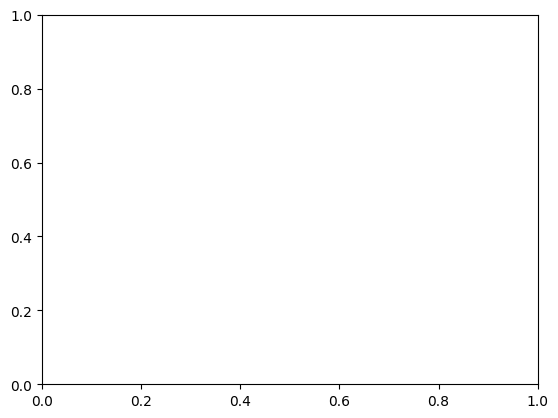

In [ ]:
fig, axs = plt.subplots(1, 1)
axs.hist(data_sf.numpy(), bins=50)
plt.show()

In [ ]:
shuffle_dataset = False

if shuffle_dataset:

  old_dataset_name = "dataset_v5_and_kaggle"
  new_datase_name = "datasetv6"
  dataset_ind = 159

  dataloader = ModelSaver(f"/home/luke/chess/python/datasets/{dataset_name}")
  boards, evals, sq_evals = dataloader.load("data_torch", id=dataset_ind)

In [ ]:
def normalise_data(data, factors, clip=None):
  """
  Normalise data based on [max, mean, std]
  """
  max, mean, std = factors
  d = ((data - mean) / std) / max
  if clip is not None:
    d = torch.clip(d, min=-clip, max=clip)
  return d

examine = False

if examine:

  factors = [23.927, -0.240, 0.355]
  factors = [3, -0.240, 0.355]
  norm_evals = normalise_data(dataset.evals, factors, clip=1)

  fig, axs = plt.subplots(1, 1)
  axs.hist(norm_evals.numpy(), bins=50)
  plt.show()

  print(torch.max(dataset.evals))
  print(torch.min(dataset.evals))

In [ ]:
rexamine = False

if rexamine:

  # load all of the dataset files to examine the data distribution
  max_values = []
  mean_values = []
  std_values = []
  for i in range(1, 11):
    this_data = datasaver.load("datasetv1", id=i)
    this_data.normalise_evaluations()
    max_values.append(this_data.norm_factor[0])
    mean_values.append(this_data.norm_factor[1])
    std_values.append(this_data.norm_factor[2])

  true_max = np.max(max_values)
  avg_mean = np.mean(mean_values)
  avg_std = np.mean(std_values)

  print(f"True max = {true_max:.3f}, true mean = {avg_mean:.3f}, average std = {avg_std:.3f}")

  norm_factors = [true_max, avg_mean, avg_std]

else:
  # True max = 23.927, true mean = -0.240, average std = 0.355
  norm_factors = [23.927, -0.240, 0.355]


In [ ]:
# def normalise_data(data, factors):
#   """
#   Normalise data based on [max, mean, std]
#   """
#   max, mean, std = factors
#   return ((data - mean) / std) / max

# def denormalise_data(data, factors):
#   """
#   Undo normalisation based on [max, mean, std]
#   """
#   max, mean, std = factors
#   return (data * max * std) + mean

def normalise_data(data, factors):
  """
  Normalise data based on [max, mean, std]
  """

  # max, mean, std = self.norm_factors[:3]

  clip, mean, std = factors
  data = torch.clip(data, min=-clip, max=clip)
  data = ((data - mean) / std)
  return data

def denormalise_data(data, factors):
  """
  Undo normalisation based on [max, mean, std]
  """
  clip, mean, std = factors
  return (data * std) + mean

def train_procedure(net, dataname, dataloader, data_inds, norm_factors,
                    epochs=1, lr=1e-7, device="cuda", batch_size=64,
                    loss_style="MSE"):
  """
  Perform a training epoch for a given network based on data inputs
  data_x, and correct outputs data_y
  """

  # move onto the specified device
  net.board_cnn.to(device)

  # put the model in training mode
  net.board_cnn.train()

  if loss_style.lower() == "mse":
    lossfcn = nn.MSELoss()
  elif loss_style.lower() == "l1":
    lossfcn = nn.L1Loss()
  elif loss_style.lower() == "huber":
    lossfcn = nn.HuberLoss()
  else:
    raise RuntimeError(f"train_procedure() error: loss_style = {loss_style} not recognised")

  optim = torch.optim.Adam(net.board_cnn.parameters(), lr=lr)
  
  # each epoch, cover the entire training dataset
  for i in range(epochs):

    print(f"Starting epoch {i + 1}.")
    total_batches = 0
    epoch_loss = 0

    # load the dataset in a series of slices
    for slice_num, j in enumerate(data_inds):

      # load this segment of the dataset
      dataset = dataloader.load(dataname, id=j)
      data_x = dataset.boards
      data_y = dataset.evals

      # import sys
      # print("The size in bytes of data_x", sys.getsizeof(data_x.storage()))
      # print("The size in bytes of data_y", sys.getsizeof(data_y.storage()))

      # normalise y labels
      data_y = normalise_data(data_y, norm_factors)

      num_batches = len(data_x) // batch_size
      total_batches += num_batches
      rand_idx = torch.randperm(data_x.shape[0])
      avg_loss = 0

      print(f"Starting slice {slice_num + 1} / {len(data_inds)}. There will be {num_batches} batches. ", end="", flush=True)

      # iterate through each batch for this slice of the dataset
      for n in range(num_batches):

        batch_x = data_x[rand_idx[n * batch_size : (n+1) * batch_size]]
        batch_y = data_y[rand_idx[n * batch_size : (n+1) * batch_size]]

        # go to cuda
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # use the model for a prediction and calculate loss
        net_y = net.board_cnn(batch_x)
        loss = lossfcn(net_y.squeeze(1), batch_y)

        # backpropagate
        loss.backward()
        optim.step()
        optim.zero_grad()

        avg_loss += loss.item()

        # if n % 500 == 0:
        #   print(f"Loss is {(avg_loss / (n + 1)) * 1000:.3f}, epoch {i + 1}, batch {n + 1} / {num_batches}")

      # this dataset slice is finished
      epoch_loss += avg_loss
      avg_loss = avg_loss / num_batches
      avg_loss = avg_loss ** 0.5 * norm_factors[0] * norm_factors[2] # try to scale to original units
      print(f"Loss is {avg_loss:.3f}, during epoch {i + 1}, slice {slice_num + 1} / {len(data_inds)}", flush=True)
  
    # this epoch is finished
    epoch_loss = epoch_loss / total_batches
    epoch_loss = epoch_loss ** 0.5 * norm_factors[0] * norm_factors[2] # try to scale to original units
    print(f"Epoch {i + 1} has finished after {total_batches} batches. Overall average loss = {epoch_loss:.3f}", flush=True)

  # finally, return the network that we have trained
  return net

do_train_procedure = False

if do_train_procedure:

  net = ChessNet(19)

  device = "cuda"
  epochs = 10
  data_inds = list(range(1, 11))
  lr = 1e-7

  trained_net = train_procedure(
    net=net,
    dataname="datasetv1",
    dataloader=ModelSaver("/home/luke/chess/python/datasets/", log_level=1),
    data_inds=list(range(1, 11)),
    norm_factors=[23.927, -0.240, 0.355], # [max, mean, std]
    epochs=epochs,
    lr=lr,
    device=device    
  )

Loading file /home/luke/chess/python/models/12-11-24/run_16-09_A1/network_005.lz4 with pickle ... finished
Loading file /home/luke/chess/python/datasets/datasetv7/data_torch_141.lz4 with pickle ... finished
The average difference from 3000 samples is u=2.645 s=4.591, stockfish average difference is u=3.233 s=2.532


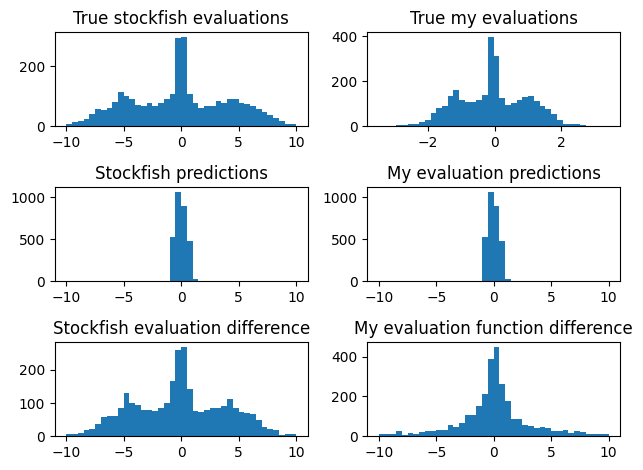

In [ ]:
def torch_to_board_vec(tensor):
  """
  Convert a torch board vector into a cpp board vector
  """

  boardvec = bf.BoardVectors()

  boardvec.wP = list(tensor[0].reshape(64))
  boardvec.wN = list(tensor[1].reshape(64))
  boardvec.wB = list(tensor[2].reshape(64))
  boardvec.wR = list(tensor[3].reshape(64))
  boardvec.wQ = list(tensor[4].reshape(64))
  boardvec.wK = list(tensor[5].reshape(64))
  boardvec.bP = list(tensor[6].reshape(64))
  boardvec.bN = list(tensor[7].reshape(64))
  boardvec.bB = list(tensor[8].reshape(64))
  boardvec.bR = list(tensor[9].reshape(64))
  boardvec.bQ = list(tensor[10].reshape(64))
  boardvec.bK = list(tensor[11].reshape(64))
  boardvec.wKS = list(tensor[12].reshape(64))
  boardvec.wQS = list(tensor[13].reshape(64))
  boardvec.bKS = list(tensor[14].reshape(64))
  boardvec.bQS = list(tensor[15].reshape(64))
  boardvec.colour = list(tensor[16].reshape(64))

  return boardvec

loadexisting = True

if loadexisting:

  if False:
    modelloader = ModelSaver("/home/luke/chess/python/models/")
    trained_net = modelloader.load("chessnet_model", id=None)
  else:
    group = "12-11-24"
    run = "run_16-09_A1"
    modelloader = ModelSaver(f"/home/luke/chess/python/models/{group}/{run}")
    trained_net = modelloader.load("network", id=None)
  
  dataset_name = "datasetv7"
  dataset_ind = 141
  dataloader = ModelSaver(f"/home/luke/chess/python/datasets/{dataset_name}")
  boards, evals, sq_evals = dataloader.load("data_torch", id=dataset_ind)

  device = "cuda"
  trained_net.to(device)
  boards = boards.to(device)
  evals = evals.to(device)
  sq_evals = sq_evals.to(device)

  trained_net.eval()

rand = False
inds = list(range(len(evals)))
if rand:
  random.shuffle(inds)

factors = [7, 0, 2.159]
factors = [10, 0, 4]
# factors = [15, 0.11, 4.369]

my_pred_vec = []
sf_pred_vec = []
my_diff_vec = []
sf_diff_vec = []
sf_vec = []
my_vec = []

avg_diff_sf = 0
avg_diff_my = 0
n = 3000
inds = inds[:n]
for i in inds:

  # board piece rating comparison
  net_eval = (trained_net(boards[i].unsqueeze(dim=0))).to("cpu").squeeze(0)
  net_eval = denormalise_data(net_eval, factors=factors)

  this_board_vec = boards[i].to("cpu")
  this_sf_eval = evals[i].to("cpu")
  this_sq_evals = sq_evals[i].to("cpu")
  this_my_eval = torch.sum(this_sq_evals).item()

  # board_vec = bf.FEN_to_board_vectors_with_eval(dataset.positions[i].fen_string)
  # board_vec = torch.tensor(board_vec.sq_evals, dtype=torch.float) * 1e-3

  if len(net_eval) == 65:
    net_sf = net_eval[0].item()
    net_my = torch.sum(net_eval[1:])
    sf_diff = this_sf_eval - net_sf
    my_diff = this_my_eval - net_my
    net_eval = net_eval[1:]

  elif len(net_eval) == 64: 
    net_sf = torch.sum(net_eval).detach()
    net_my = torch.sum(net_eval).detach()
    sf_diff = this_sf_eval - net_my
    my_diff = this_my_eval - net_my

  else: raise RuntimeError(f"len(net_eval) = {len(net_eval)}")

  net_print = torch.zeros((8, 8))
  true_print = torch.zeros((8, 8))
  
  torch.round(net_eval.reshape(8,8).detach(), decimals=2, out=net_print)
  torch.round(this_sq_evals.reshape(8,8).detach(), decimals=2, out=true_print)

  my_pred_vec.append(net_my.item())
  my_diff_vec.append(my_diff.detach().item())
  sf_pred_vec.append(net_sf)
  sf_diff_vec.append(sf_diff.detach().item())
  sf_vec.append(this_sf_eval.detach().item())
  my_vec.append(this_my_eval)

  avg_diff_sf += abs(sf_diff)
  avg_diff_my += abs(my_diff)
  
  if n <= 50:
    print(f"Case {i + 1} / {n}.", end=" ")
    if n < 6:
      print("Board:")
      bf.print_board_vectors(torch_to_board_vec(this_board_vec))
      # bf.print_FEN_board(dataset.positions[i].fen_string)
      print("Net eval was\n", net_print)
      print("Ground truth was\n", true_print)
    print(f"sf_eval = {this_sf_eval:.3f}, True evaluation = {this_my_eval:.3f}, net eval = {net_overall:.3f}, difference = {this_my_eval - net_overall:.3f}")

diff_sf = np.array(sf_diff_vec)
mean_sf_diff = np.mean(np.abs(diff_sf))
std_sf_diff = np.std(np.abs(diff_sf))

diff_my = np.array(my_diff_vec)
mean_my_diff = np.mean(np.abs(diff_my))
std_my_diff = np.std(diff_my)

sf_vec = np.array(sf_vec)

print(f"The average difference from {n} samples is u={mean_my_diff:.3f} s={std_my_diff:.3f}, stockfish average difference is u={mean_sf_diff:.3f} s={std_sf_diff:.3f}")

fig, axs = plt.subplots(3, 2)
# axs[0].hist(evals.detach().to("cpu").numpy(), bins=40, range=(-10, 10))

norm = normalise_data(torch.tensor(sf_vec), factors=[15, 0.11, 4.37])
norm = norm.detach().numpy()

axs[0][0].hist(sf_vec, bins=40, range=(-10, 10))
axs[1][0].hist(sf_pred_vec, bins=40, range=(-10, 10))
axs[2][0].hist(diff_sf, bins=40, range=(-10, 10))
axs[0][1].hist(norm, bins=40)
axs[1][1].hist(my_pred_vec, bins=40, range=(-10, 10))
axs[2][1].hist(diff_my, bins=40, range=(-10, 10))
axs[0][0].set_title("True stockfish evaluations")
axs[1][0].set_title("Stockfish predictions")
axs[2][0].set_title("Stockfish evaluation difference")
axs[0][1].set_title("True my evaluations")
axs[1][1].set_title("My evaluation predictions")
axs[2][1].set_title("My evaluation function difference")
fig.tight_layout()
plt.show()

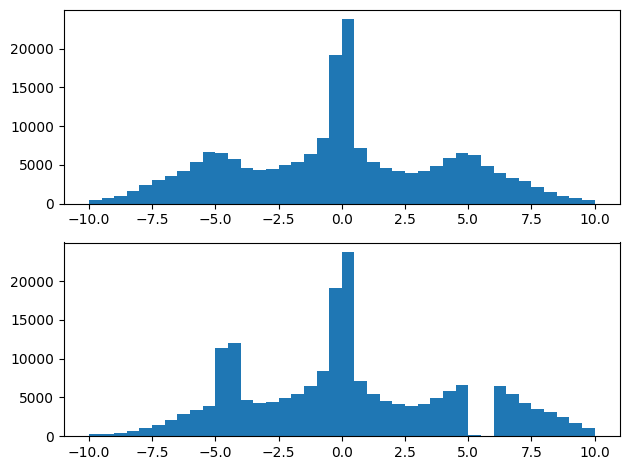

In [ ]:
np_evals = evals.detach().to("cpu").numpy()
shifted_evals = np.copy(np_evals) 
shifted_evals[np.abs(np_evals) > 5] = 10 - shifted_evals[np.abs(np_evals) > 5]

fig, axs = plt.subplots(2, 1)
axs[0].hist(np_evals, bins=40, range=(-10, 10))
axs[1].hist(shifted_evals, bins=40, range=(-10, 10))
# axs[0][0].hist(sf_vec, bins=40, range=(-10, 10))
# axs[1][0].hist(sf_pred_vec, bins=40, range=(-10, 10))
# axs[2][0].hist(diff_sf, bins=40, range=(-10, 10))
# axs[0][1].hist(my_vec, bins=40, range=(-10, 10))
# axs[1][1].hist(my_pred_vec, bins=40, range=(-10, 10))
# axs[2][1].hist(diff_my, bins=40, range=(-10, 10))
# axs[0][0].set_title("True stockfish evaluations")
# axs[1][0].set_title("Stockfish predictions")
# axs[2][0].set_title("Stockfish evaluation difference")
# axs[0][1].set_title("True my evaluations")
# axs[1][1].set_title("My evaluation predictions")
# axs[2][1].set_title("My evaluation function difference")
fig.tight_layout()
plt.show()

In [ ]:
time_net = True

if time_net:

  timedevice = "cpu"
  trained_net.board_cnn.eval()
  trained_net.board_cnn.to(timedevice)
  static_board = boards[0].to(timedevice).unsqueeze(dim=0)
  num = 1000
  j = 0

  t1 = time.process_time()
  for i in range(num):
    trained_net.board_cnn(static_board)
    j += 1
    if j >= len(boards):
      j = 0
  t2 = time.process_time()

  print(f"Network: Total time {t2 - t1:.1f}s, so {((t2 - t1) / num) * 1e3:.3f} ms per evaluation (approx {1 / (30 * (t2 - t1) / num):.1f} boards per s)")

  t1 = time.process_time()
  for i in range(num):
    bf.generate_moves_FEN(dataset.positions[j].fen_string)
    j += 1
    if j >= len(dataset.boards):
      j = 0
  t2 = time.process_time()

  print(f"Handcrafted: Total time {t2 - t1:.1f}s, so {((t2 - t1) / num) * 1e3:.3f} ms per board (approx {1 / ((t2 - t1) / num):.1f} boards per s)")

Network: Total time 0.3s, so 0.302 ms per evaluation (approx 110.3 boards per s)
Handcrafted: Total time 0.4s, so 0.382 ms per board (approx 2615.0 boards per s)


In [ ]:
print(dataloader.get_current_path())
print(dataloader.path)

/home/luke/chess/python/datasets/datasetv5/
/home/luke/chess/python/datasets/datasetv5/


In [ ]:
# trace model, but move to the cpu before saving
trained_net.to("cpu")
example = boards[0].unsqueeze(dim=0).to("cpu")
traced_net = torch.jit.trace(trained_net, example)

traced_net.save("/home/luke/chess/python/models/traced_model.pt")